In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
from tqdm.auto import tqdm
from collections import namedtuple
from datasets import load_dataset

pd.set_option("max_colwidth", 200)
pd.set_option("display.max_rows", 200)

# BoolQ data

In [2]:
dataset = load_dataset("boolq")

Using custom data configuration default
Reusing dataset boolq (/Users/yoelz/.cache/huggingface/datasets/boolq/default/0.1.0/bf0dd57da941c50de94ae3ce3cef7fea48c08f337a4b7aac484e9dddc5aa24e5)


  0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
np.random.seed(12)

df_train = dataset['train'].to_pandas()
df_test = dataset['validation'].to_pandas()
df_test = df_test.sample(frac=1, replace=False)
df_train

,question,answer,passage
0,do iran and afghanistan speak the same language,True,"Persian (/ˈpɜːrʒən, -ʃən/), also known by its endonym Farsi (فارسی fārsi (fɒːɾˈsiː) ( listen)), is one of the Western Iranian languages within the Indo-Iranian branch of the Indo-European language..."
1,do good samaritan laws protect those who help at an accident,True,"Good Samaritan laws offer legal protection to people who give reasonable assistance to those who are, or who they believe to be, injured, ill, in peril, or otherwise incapacitated. The protection ..."
2,is windows movie maker part of windows essentials,True,Windows Movie Maker (formerly known as Windows Live Movie Maker in Windows 7) is a discontinued video editing software by Microsoft. It is a part of Windows Essentials software suite and offers th...
3,is confectionary sugar the same as powdered sugar,True,"Powdered sugar, also called confectioners' sugar, icing sugar, and icing cake, is a finely ground sugar produced by milling granulated sugar into a powdered state. It usually contains a small amou..."
4,is elder scrolls online the same as skyrim,False,"As with other games in The Elder Scrolls series, the game is set on the continent of Tamriel. The events of the game occur a millennium before those of The Elder Scrolls V: Skyrim and around 800 y..."
...,...,...,...
9422,is a us district court a federal court,True,"The United States district courts are the general trial courts of the United States federal court system. Both civil and criminal cases are filed in the district court, which is a court of law, eq..."
9423,can a tenant get a restraining order against a landlord,True,"If a landlord is found to be retaliating, he or she will not be able to evict the tenant, who may also be awarded damages from the landlord of one to three months' rent plus attorney's fees. The l..."
9424,is the golden state warriors in the playoffs,True,The Warriors went into the 2018 playoffs as the second seed in the Western Conference after earning a 2017--18 regular season record of 58--24 . After defeating both the Spurs and the Pelicans 4-1...
9425,downton abbey will there be a season 7,False,Downton Abbey is a British period drama television series created by Julian Fellowes and co-produced by Carnival Films and Masterpiece. It first aired on ITV in the United Kingdom on 26 September ...


In [4]:
df_train['answer'].value_counts(normalize=True)

True     0.623104
False    0.376896
Name: answer, dtype: float64

# Prompt

In [5]:
np.random.seed(42)
prompt_size = 10

prompt_examples = (pd.concat([
    df_train[df_train['answer']].sample(prompt_size // 2, replace=False),
    df_train[~df_train['answer']].sample(prompt_size // 2, replace=False)
], axis=0).sample(frac=1, replace=False))

prompt_text = (
    '\n\n'.join(prompt_examples['passage'] +
              '\nQuestion: ' +
              prompt_examples['question'].str.rstrip('?') +
              '?\nAnswer: ' +
              prompt_examples['answer'].map(str))
)

print(prompt_text)

Argentina (/ˌɑːrdʒənˈtiːnə/ ( listen); Spanish: (aɾxenˈtina)), officially the Argentine Republic (Spanish: República Argentina), is a federal republic in the southern portion of South America. Sharing the bulk of the Southern Cone with its neighbor Chile to the west, the country is also bordered by Bolivia and Paraguay to the north, Brazil to the northeast, Uruguay and the South Atlantic Ocean to the east, and the Drake Passage to the south. With a mainland area of 2,780,400 km (1,073,500 sq mi), Argentina is the eighth-largest country in the world, the second largest in Latin America, and the largest Spanish-speaking nation. It is subdivided into twenty-three provinces (Spanish: provincias, singular provincia) and one autonomous city (ciudad autónoma), Buenos Aires, which is the federal capital of the nation (Spanish: Capital Federal) as decided by Congress. The provinces and the capital have their own constitutions, but exist under a federal system. Argentina claims sovereignty over 

In [6]:
def generate_text_from_j1(input_text):
    with open("api_key", "r") as f:
        api_key = f.read().strip()
        
    res = requests.post("https://api.ai21.com/studio/v1/j1-jumbo/complete",
        headers={"Authorization": api_key},
        json={
            "prompt": input_text,
            "numResults": 1,
            "maxTokens": 3,
            "temperature": 0,
            "topKReturn": 0,
            "topP":1,
            "countPenalty": {
                "scale": 0,
                "applyToNumbers": False,
                "applyToPunctuations": False,
                "applyToStopwords": False,
                "applyToWhitespaces": False,
                "applyToEmojis": False
            },
            "frequencyPenalty": {
                "scale": 0,
                "applyToNumbers": False,
                "applyToPunctuations": False,
                "applyToStopwords": False,
                "applyToWhitespaces": False,
                "applyToEmojis": False
            },
            "presencePenalty": {
                "scale": 0,
                "applyToNumbers": False,
                "applyToPunctuations": False,
                "applyToStopwords": False,
                "applyToWhitespaces": False,
                "applyToEmojis": False
          },
          "stopSequences":['\n']
        }
    )
    
    return json.loads(res.content.decode())['completions'][0]['data']['text']


Res = namedtuple("Res", ['pred', 'generated_text'])


def predict(prompt, passage, question):
    prompt_to_j1 = (
        f'{prompt}\n\n{passage}\nQuestion: {question.rstrip("?")}?' +
        '\nAnswer:'
    )
    
    completion = generate_text_from_j1(prompt_to_j1)
    if "True" in completion:
        return Res(pred=True, generated_text=completion)
    elif "False" in completion:
        return Res(pred=False, generated_text=completion)
    else:
        return Res(pred=-1, generated_text=completion)

# Predict BoolQ for test set

In [7]:
results_df = pd.DataFrame()
for _, row in tqdm(list(df_test.iloc[:20].iterrows())):
    res = predict(prompt_text, row['passage'], row['question'])
    results_df = results_df.append({
        'pred': res.pred,
        'label': row['answer'],
        'passage': row['passage'],
        'question': row['question'], 
        'generated_text': res.generated_text
    }, ignore_index=True)
    results_known_df = results_df[results_df['pred'] != -1]
    print(f'Accuracy: {(results_known_df["pred"] == results_known_df["label"]).mean()}')
    print(f'Coverage: {len(results_known_df) / len(results_df)}\n')

  0%|          | 0/20 [00:00<?, ?it/s]

<ipython-input-7-0f0cc4cdb05e>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Accuracy: 0.0
Coverage: 1.0



<ipython-input-7-0f0cc4cdb05e>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Accuracy: 0.5
Coverage: 1.0



<ipython-input-7-0f0cc4cdb05e>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Accuracy: 0.6666666666666666
Coverage: 1.0



<ipython-input-7-0f0cc4cdb05e>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Accuracy: 0.75
Coverage: 1.0



<ipython-input-7-0f0cc4cdb05e>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Accuracy: 0.8
Coverage: 1.0



<ipython-input-7-0f0cc4cdb05e>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Accuracy: 0.8333333333333334
Coverage: 1.0



<ipython-input-7-0f0cc4cdb05e>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Accuracy: 0.8571428571428571
Coverage: 1.0



<ipython-input-7-0f0cc4cdb05e>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Accuracy: 0.875
Coverage: 1.0



<ipython-input-7-0f0cc4cdb05e>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Accuracy: 0.7777777777777778
Coverage: 1.0



<ipython-input-7-0f0cc4cdb05e>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Accuracy: 0.8
Coverage: 1.0



<ipython-input-7-0f0cc4cdb05e>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Accuracy: 0.7272727272727273
Coverage: 1.0



<ipython-input-7-0f0cc4cdb05e>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Accuracy: 0.75
Coverage: 1.0



<ipython-input-7-0f0cc4cdb05e>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Accuracy: 0.7692307692307693
Coverage: 1.0



<ipython-input-7-0f0cc4cdb05e>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Accuracy: 0.7857142857142857
Coverage: 1.0



<ipython-input-7-0f0cc4cdb05e>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Accuracy: 0.8
Coverage: 1.0



<ipython-input-7-0f0cc4cdb05e>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Accuracy: 0.8125
Coverage: 1.0



<ipython-input-7-0f0cc4cdb05e>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Accuracy: 0.7647058823529411
Coverage: 1.0



<ipython-input-7-0f0cc4cdb05e>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Accuracy: 0.7777777777777778
Coverage: 1.0



<ipython-input-7-0f0cc4cdb05e>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Accuracy: 0.7894736842105263
Coverage: 1.0

Accuracy: 0.8
Coverage: 1.0



<ipython-input-7-0f0cc4cdb05e>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


In [8]:
def create_prompt(idx):
    np.random.seed(idx)
    prompt_size = 10

    prompt_examples = (pd.concat([
        df_train[df_train['answer']].sample(prompt_size // 2, replace=False),
        df_train[~df_train['answer']].sample(prompt_size // 2, replace=False)
    ], axis=0).sample(frac=1, replace=False))

    prompt_text = (
        '\n\n'.join(prompt_examples['passage'] +
                  '\nQuestion: ' +
                  prompt_examples['question'].str.rstrip('?') +
                  '?\nAnswer: ' +
                  prompt_examples['answer'].map(str))
    )

    return prompt_text

In [9]:
from scipy.stats import beta


def get_score(single_bandit):
    return np.random.beta(single_bandit['n_successes'], single_bandit['n_failures'])


def choose_bandit(bandits):
    return np.argmax([get_score(single_bandit) for single_bandit in bandits])


def run_bandit(chosen_bandit):
    while True:
        example = df_test.iloc[(chosen_bandit['n_successes'] + 
                                chosen_bandit['n_failures'] + 
                                chosen_bandit['n_unknowns'])]

        pred = predict(chosen_bandit['prompt'], example['passage'], example['question']).pred
        if pred == -1:
            chosen_bandit['n_unknowns'] += 1
            continue
        elif pred == example['answer']:
            chosen_bandit['n_successes'] += 1 
        else:
            chosen_bandit['n_failures'] += 1
        return
    
    
def plot_bandits(bandits, chosen_bandit):
    xs = np.linspace(0, 1, 100)
    for bandit in bandits:
        sns.lineplot(x=xs,
                     y=[beta(bandit['n_successes'], bandit['n_failures']).pdf(x) for x in xs],
                     label=f'prompt_{bandit["id"]}')
    plt.title(f'chosen prompt_{chosen_bandit["id"]}')
    plt.show()


def run(bandits, n_iterations=100):
    for idx in range(n_iterations):
        chosen_bandit = bandits[choose_bandit(bandits)]
        run_bandit(chosen_bandit)
        plot_bandits(bandits, chosen_bandit)

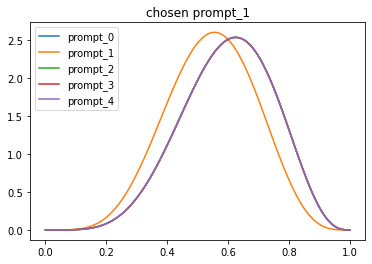

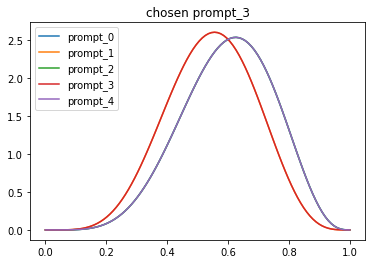

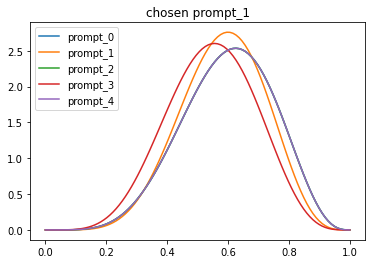

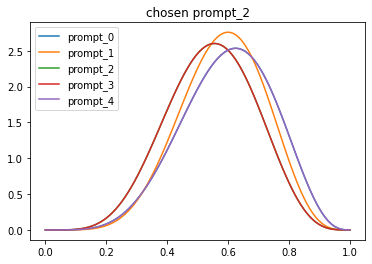

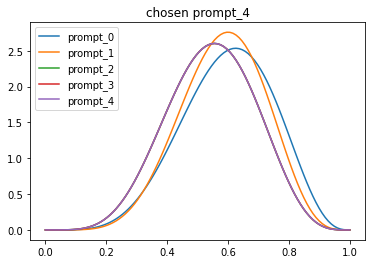

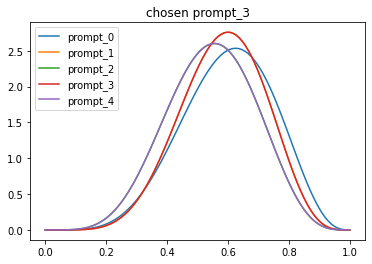

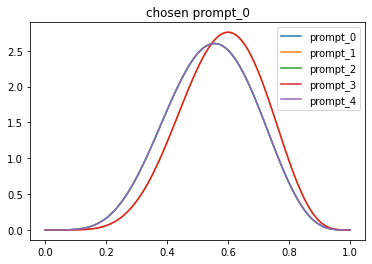

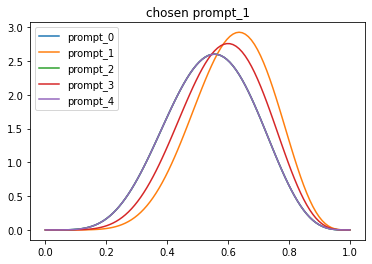

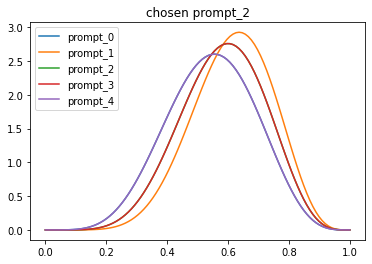

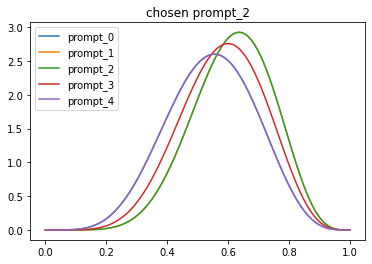

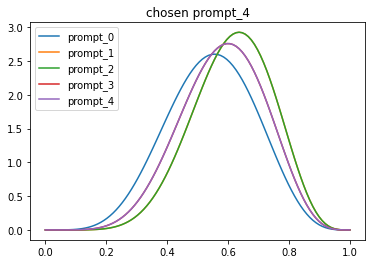

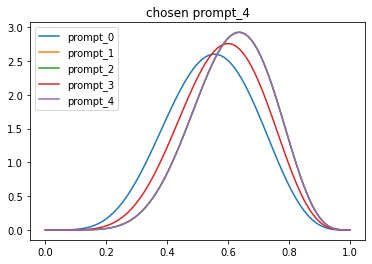

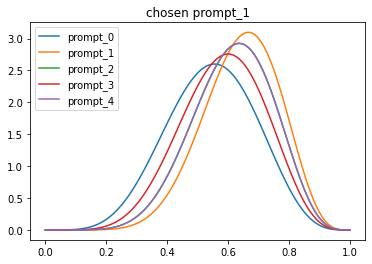

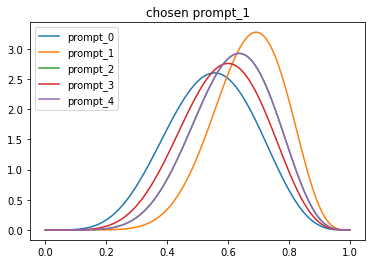

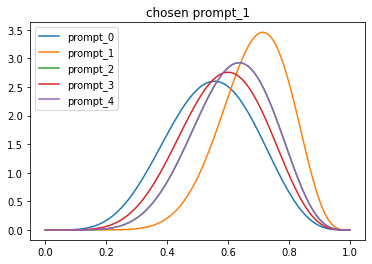

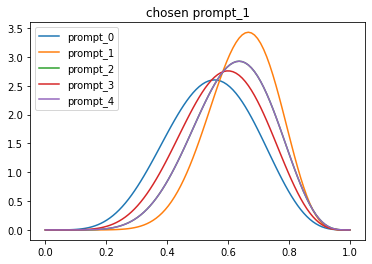

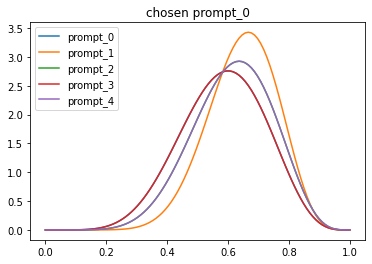

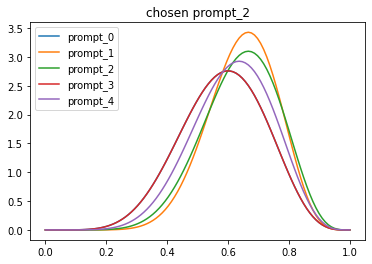

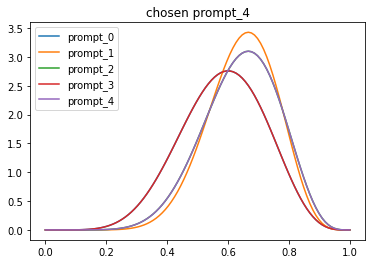

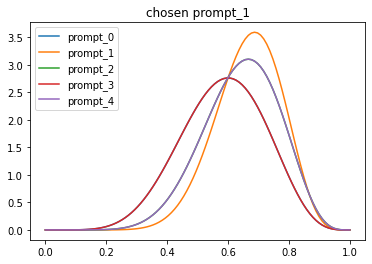

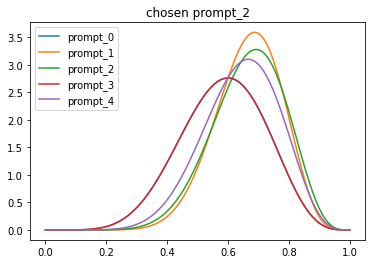

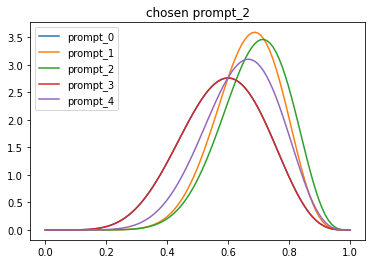

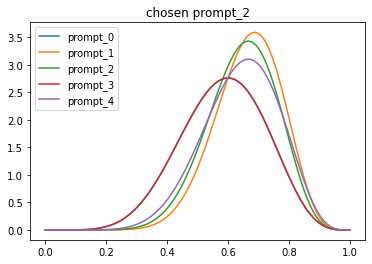

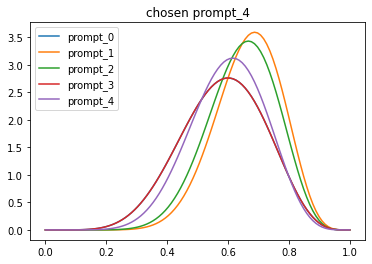

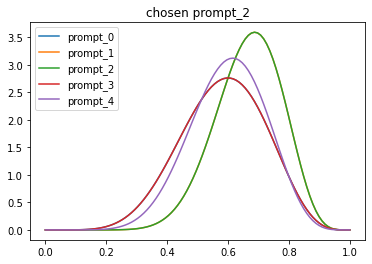

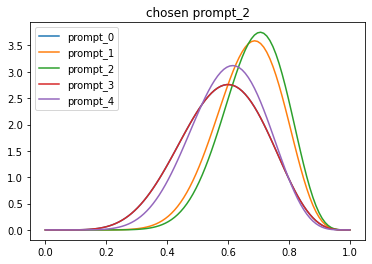

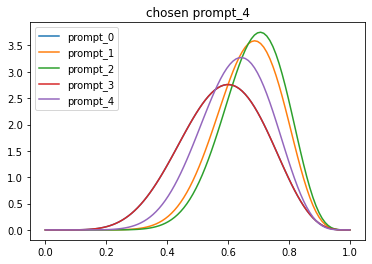

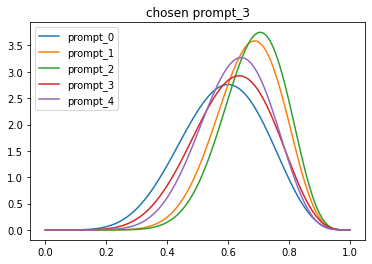

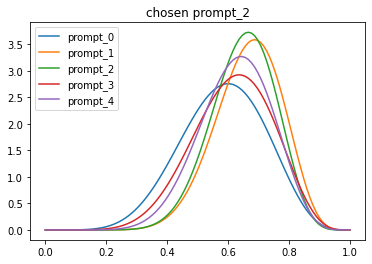

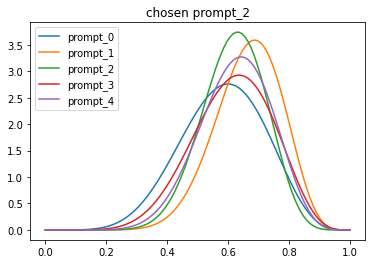

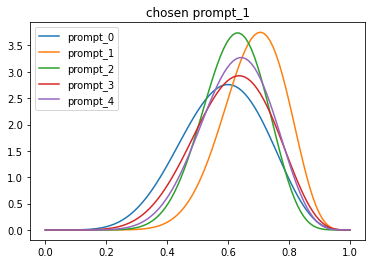

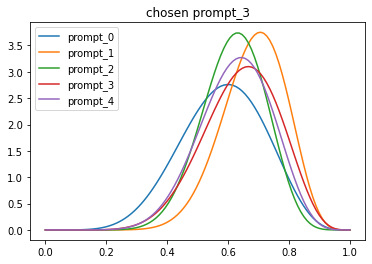

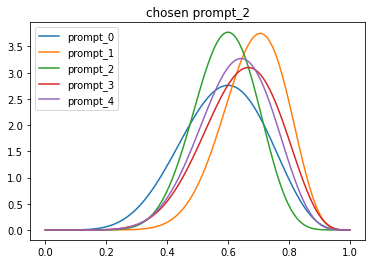

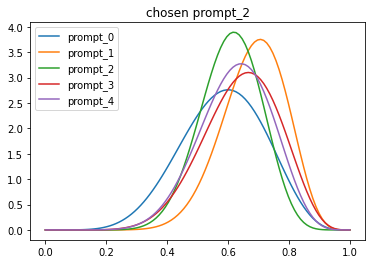

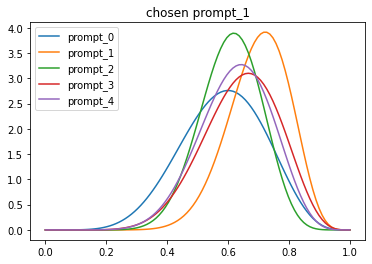

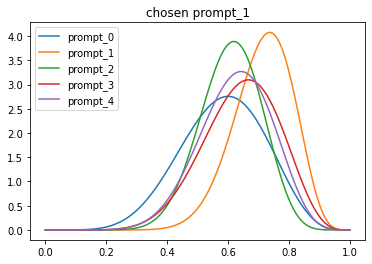

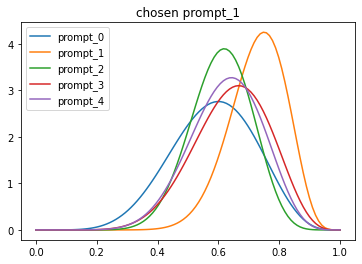

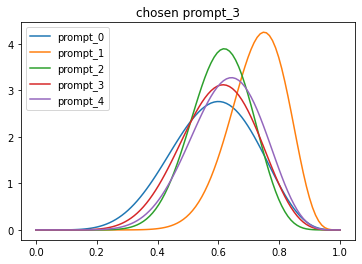

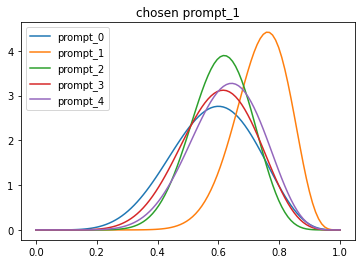

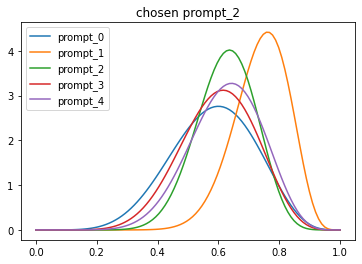

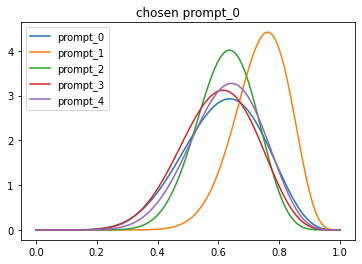

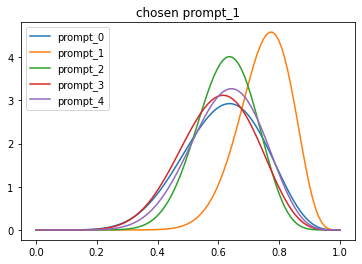

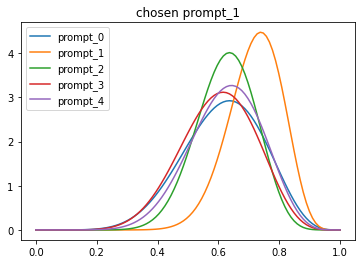

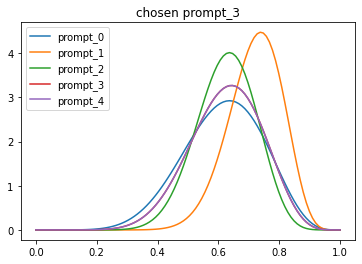

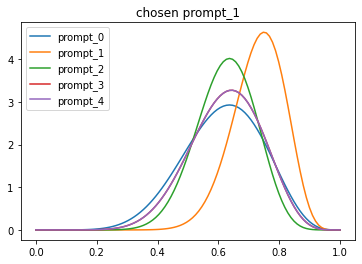

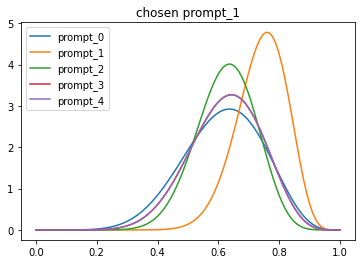

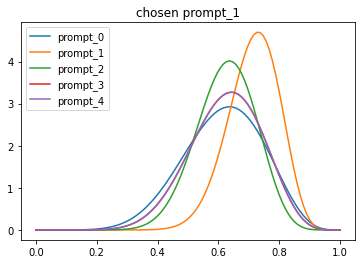

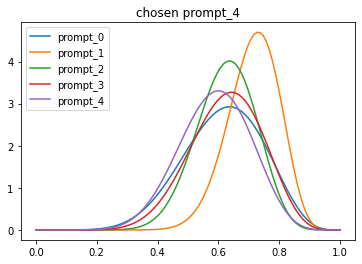

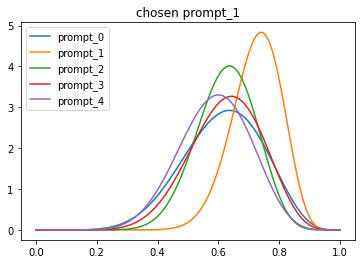

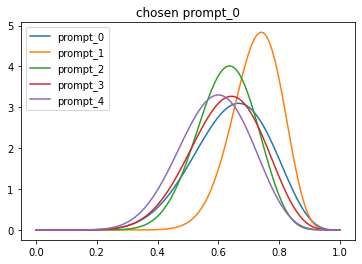

In [10]:
bandits = [{
    'id': idx,
    'n_successes': 6,
    'n_failures': 4,
    'n_unknowns': 0,
    'prompt': create_prompt(idx)
} for idx in range(5)]

run(bandits, 50)

In [11]:
print('\n'.join([f"#successes: {bandit['n_successes']}, " +
                 f"#failures: {bandit['n_failures']}, " + 
                 "n unknown: {bandit['n_unknowns']})"
                 for bandit in bandits]))

#successes: 9, #failures: 5, n unknown: {bandit['n_unknowns']})
#successes: 21, #failures: 8, n unknown: {bandit['n_unknowns']})
#successes: 15, #failures: 9, n unknown: {bandit['n_unknowns']})
#successes: 10, #failures: 6, n unknown: {bandit['n_unknowns']})
#successes: 10, #failures: 7, n unknown: {bandit['n_unknowns']})
